# Uniaxial tension of a 3D cube with a spherical inclusion

### Units
- Length: mm
- Mass: kg
- Time:  s
- Force: milliNewtons
- Stress: kPa 

### Software:
- Dolfinx v0.8.0


Accompanies the book, 
- L. Anand, E.M. Stewart, S.A. Chester. _Introduction to coupled theories in solid mechanics_. 2025, in preparation.


# Import modules

In [1]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile


# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split)

# basix finite elements (necessary for dolfinx v0.8.0)
import basix
from basix.ufl import element, mixed_element, quadrature_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime


# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [2]:
# Dimensions of one quarter of hole in plate specimen
#
length = 10.0   # Side length in mm

# Pull in the mesh *.xdmf file and read any named domains in the mesh.
with XDMFFile(MPI.COMM_WORLD,"meshes/sphere_inclusion.xdmf",'r') as infile:
    domain = infile.read_mesh(name="Grid",xpath="/Xdmf/Domain")
    cell_tags = infile.read_meshtags(domain,name="Grid")

# Create facet to cell connectivity required to determine boundary facets.
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)

x = ufl.SpatialCoordinate(domain)

**Identify boundaries of the domain**

In [3]:
# Identify the planar boundaries of the  box mesh
#
def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], length)
def yBot(x):
    return np.isclose(x[1], 0)
def yTop(x):
    return np.isclose(x[1], length)
def zBot(x):
    return np.isclose(x[2], 0)
def zTop(x):
    return np.isclose(x[2], length)
    
# Mark the sub-domains
boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,zTop)]

# build collections of facets on each subdomain and mark them appropriately.
facet_indices, facet_markers = [], [] # initalize empty collections of indices and markers.
fdim = domain.topology.dim - 1 # geometric dimension of the facet (mesh dimension - 1)
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator) # an array of all the facets in a 
                                                         # given subdomain ("locator")
    facet_indices.append(facets)                         # add these facets to the collection.
    facet_markers.append(np.full_like(facets, marker))   # mark them with the appropriate index.

# Format the facet indices and markers as required for use in dolfinx.
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
# 
# Add these marked facets as "mesh tags" for later use in BCs.
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

**Print out the unique facet index numbers**

In [4]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain (facets)
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

# Surface numbering:
# boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,zTop)]

# Volume numbering:
# Physical Volume("inclusion", 32) = {2};
# Physical Volume("matrix", 33) = {1};

[1 2 3 4 5 6]


**Visualize reference configuration and boundary facets**

In [5]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the 3D mesh domains
inclusion = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim,cell_tags.indices[cell_tags.values==32]) )
matrix    = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim,cell_tags.indices[cell_tags.values==33]) )
# 
actor1 = plotter.add_mesh(inclusion, show_edges=True,color= "red") # inclusion material is red
actor2 = plotter.add_mesh(matrix, show_edges=True,color="blue") # matrix material is blue

labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

# turn the camera around so that the inclusion is visible
plotter.camera.azimuth = 180.0

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot("mesh.png")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Define boundary and volume integration measure

In [6]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" using the cell tags,
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, subdomain_data=cell_tags, metadata={'quadrature_degree': 4})

#  Define facet normal
n = ufl.FacetNormal(domain)

# Material parameters
-Arruda-Boyce model

In [7]:
# The two different shear modulus values (just floats for now):
Gshear_0_matrix   = Constant(domain,PETSc.ScalarType(280.0)) # Matrix shear modulus, kPa
Gshear_0_inclusion = Constant(domain,PETSc.ScalarType(10*Gshear_0_matrix)) # Matrix shear modulus, kPa
#Gshear_0_inclusion = 10*Gshear_0_matrix # Inclusion shear modulus, kPa

# Need some extra infrastructure for the spatially-discontinuous material property fields
V = functionspace(domain, ("DG", 0)) # create a DG0 function space on the domain
Gshear_0 = Function(V) # define a ground state shear modulus which lives on this function space.

# Now, actualy assign the desired values of shear moduli to the new field.
#
coords = V.tabulate_dof_coordinates()
#
# loop over the coordinates and assign the relevant material property, 
# based on the local cell tag number.
for i in range(coords.shape[0]):
    if cell_tags.values[i] == 32:
        Gshear_0.vector.setValueLocal(i, Gshear_0_inclusion)
    else:
        Gshear_0.vector.setValueLocal(i, Gshear_0_matrix)
        
# Volume numbering:
# Physical Volume("inclusion", 32) = {2};
# Physical Volume("matrix", 33) = {1};

# Now for the other material properties
lambdaL  = Constant(domain,PETSc.ScalarType(5.12))  # Locking stretch, same for both materials
Kbulk    = 1000.0*Gshear_0 # the bulk modulus is still 1000x the (spatially-varying) shear modulus.


## Showing the material properties in a plotter 

In [8]:
pyvista.set_jupyter_backend('html')
pyvista.start_xvfb()

# Prepare the gshear field for plotting
V = functionspace(domain,("DG",1)) # for some reason, we need a degree 1 DG function space in order to plot in Pyvista.
vtkdata = vtk_mesh(V)  
grid = pyvista.UnstructuredGrid(*vtkdata)
# 
grid["Gshear"] = Gshear_0.x.array # interpolate the Gshear_0 data onto the DG1 space.
#
grid.set_active_scalars("Gshear")
actor = plotter.add_mesh(grid, show_edges=True) # plot Gshear_0 values.

labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

# turn the camera around so that the inclusion is visible
plotter.camera.azimuth = 180.0

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot("mesh.png")


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

# Simulation time-control related params

In [9]:
stretch  = 2.0      # stretch amplitude

dispTot  = (stretch-1)*length
rate     = 1.e-1
Ttot     = (stretch-1)/rate
numSteps = 50
dt       = Ttot/numSteps  # (fixed) step size
t        = 0.0

def dispRamp(t):
    return dispTot*t/Ttot

# Function spaces

In [10]:
# Define function space, both vectorial and scalar

# dolfinx v0.8.0 syntax:   
U2 = element("Lagrange", domain.basix_cell(), 2, shape=(3,)) # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1)  # For  pressure                                         
#
TH = mixed_element([U2, P1])     # Taylor-Hood style mixed element
ME = functionspace(domain, TH)    # Total space for all DOFs

# Define actual functions with the required DOFs
w    = Function(ME)
u, p = split(w)  # displacement u, pressure p

# A copy of functions to store values in the previous step
w_old         = Function(ME)
u_old,  p_old = split(w_old)   

# Define test functions        
u_test, p_test = TestFunctions(ME)    

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)                  

# Subroutines for kinematics and constitutive equations

In [11]:
# Deformation gradient 
def F_calc(u):
    Id = Identity(3) 
    F  = Id + grad(u)
    return F

def lambdaBar_calc(u):
    F = F_calc(u)
    C = F.T*F
    Cdis = J**(-2/3)*C
    I1 = tr(Cdis)
    lambdaBar = sqrt(I1/3.0)
    return lambdaBar

def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u)
    # Use Pade approximation of Langevin inverse
    z    = lambdaBar/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep simulation from blowing up
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta = (lambdaL/(3*lambdaBar))*beta
    return zeta

# Generalized shear modulus for Arruda-Boyce model
def Gshear_AB_calc(u):
    zeta    = zeta_calc(u)
    Gshear  = Gshear_0 * zeta
    return Gshear

#---------------------------------------------
# Subroutine for calculating the Cauchy stress
#---------------------------------------------
def T_calc(u,p):
    Id = Identity(3) 
    F   = F_calc(u)
    J = det(F)
    B = F*F.T
    Bdis = J**(-2/3)*B
    Gshear  = Gshear_AB_calc(u)
    T = (1/J)* Gshear * dev(Bdis) - p * Id
    return T

#----------------------------------------------
# Subroutine for calculating the Piola  stress
#----------------------------------------------
def Piola_calc(u, p):
    Id = Identity(3) 
    F   = F_calc(u)
    J = det(F)
    #
    T   = T_calc(u,p)
    #
    Tmat   = J * T * inv(F.T)
    return Tmat

# Evaluate kinematics and constitutive relations

In [12]:
F =  F_calc(u)  
J = det(F)
lambdaBar = lambdaBar_calc(u)

# Piola stress
Tmat = Piola_calc(u, p)

# Weak forms

In [13]:
# Residuals:
# Res_0: Balance of forces (test fxn: u)
# Res_1: Coupling pressure (test fxn: p)

# The weak form for the equilibrium equation. No body force
Res_0 = inner(Tmat , grad(u_test) )*dx

# The weak form for the pressure
fac_p = ln(J)/J
#
Res_1 = dot( (p/Kbulk + fac_p), p_test)*dx

# Total weak form
Res = Res_0 +  Res_1 

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [14]:
# results file name
results_name = "3D_spherical_inclusion"

# Function space for projection of results
# v0.8.0 syntax:
U1 = element("DG", domain.basix_cell(), 1, shape=(3,)) # For displacement
P0 = element("DG", domain.basix_cell(), 1)             # For  pressure  

V2 = fem.functionspace(domain, U1) #Vector function space
V1 = fem.functionspace(domain, P0) #Scalar function space

# fields to write to output file
u_vis = Function(V2)
u_vis.name = "disp"

p_vis = Function(V1)
p_vis.name = "p"

J_vis = Function(V1)
J_vis.name = "J"
J_expr = Expression(J,V1.element.interpolation_points())

lambdaBar_vis = Function(V1)
lambdaBar_vis.name = "lambdaBar"
lambdaBar_expr = Expression(lambdaBar,V1.element.interpolation_points())

P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Tmat[0,0],V1.element.interpolation_points())
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Tmat[1,1],V1.element.interpolation_points())
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Tmat[2,2],V1.element.interpolation_points())

T   = Tmat*F.T/J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_vis= Function(V1,name="Mises")
Mises_expr = Expression(Mises,V1.element.interpolation_points())

Gshear_vis = Function(V1)
Gshear_vis.name = "Gshear"
Gshear_expr = Expression(Gshear_0,V1.element.interpolation_points())

# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, J_vis, P11, P22, P33, lambdaBar_vis,
        Mises_vis, Gshear_vis,
    ],
    engine="BP4",
)

def writeResults(t):
       # Output field interpolation 
       u_vis.interpolate(w.sub(0))
       p_vis.interpolate(w.sub(1))
       J_vis.interpolate(J_expr)
       P11.interpolate(P11_expr)
       P22.interpolate(P22_expr)
       P33.interpolate(P33_expr)
       lambdaBar_vis.interpolate(lambdaBar_expr)
       Mises_vis.interpolate(Mises_expr)
       Gshear_vis.interpolate(Gshear_expr)
       
       # Write output fields
       file_results.write(t) 
        

# Infrastructure for pulling out time history data (force, displacement, etc.)

In [15]:

# infrastructure for pulling out displacement at a certain point

# v0.8.0 syntax:
pointForDisp = np.array([length,length,length])

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForDisp)

# v0.7.2 syntax:
# colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForDisp)

# v0.8.0 syntax:
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForDisp).array
 
# computing the reaction force using the stress field
area     = Constant(domain,(length*length))
engineeringStress = fem.form(P22/area*ds(4)) #P22/area*ds   

# Recall the boundary definitions:
# boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,zTop)]

# Name the analysis step

In [16]:
# Give the step a descriptive name
step = "Stretch"

## Boundary condtions

In [17]:
# Constant for applied displacement
disp_cons = Constant(domain,PETSc.ScalarType(dispRamp(0)))

# Find the specific DOFs which will be constrained.
xBot_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(1))
yBot_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(3))
zBot_u3_dofs = fem.locate_dofs_topological(ME.sub(0).sub(2), facet_tags.dim, facet_tags.find(5))
yTop_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(4))

# building Dirichlet BCs
bcs_1 = dirichletbc(0.0, xBot_u1_dofs, ME.sub(0).sub(0))  # u1 fix - xBot
bcs_2 = dirichletbc(0.0, yBot_u2_dofs, ME.sub(0).sub(1))  # u2 fix - yBot
bcs_3 = dirichletbc(0.0, zBot_u3_dofs, ME.sub(0).sub(2))  # u3 fix - zBot
#
bcs_4 = dirichletbc(disp_cons, yTop_u2_dofs, ME.sub(0).sub(1))  # disp ramp - yTop

bcs = [bcs_1, bcs_2, bcs_3, bcs_4]

## Define the nonlinear variational problem

In [18]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# the global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly" # "preonly" works equally well
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()



##  Start calculation loop

In [19]:
# Variables for storing time history
totSteps = numSteps+1
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 
timeHist2 = np.zeros(shape=[totSteps]) 

#Iinitialize a counter for reporting data
ii=0

# Write initial state to file
writeResults(t=0.0)   

# Print out message for simulation start
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    disp_cons.value = dispRamp(t)
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        print("Ended Early")
        break
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()
    
    # Write output to file
    writeResults(t)
    
    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
   
    # Store  displacement and stress at a particular point  at this time
    timeHist0[ii] = w.sub(0).sub(1).eval([length, length, length],colliding_cells[0])[0] # time history of displacement
    #
    timeHist1[ii] =  domain.comm.gather(fem.assemble_scalar(engineeringStress))[0] # time history of engineering stress
   
    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Increment: {}, Iterations: {}".\
              format(step, ii, iter))
        print("      Simulation Time: {} s  of  {} s".\
              format(round(t,4), Ttot))
        print()  
    

# close the output file.
file_results.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Stretch | Increment: 1, Iterations: 4
      Simulation Time: 0.2 s  of  10.0 s

Step: Stretch | Increment: 2, Iterations: 4
      Simulation Time: 0.4 s  of  10.0 s

Step: Stretch | Increment: 3, Iterations: 4
      Simulation Time: 0.6 s  of  10.0 s

Step: Stretch | Increment: 4, Iterations: 4
      Simulation Time: 0.8 s  of  10.0 s

Step: Stretch | Increment: 5, Iterations: 4
      Simulation Time: 1.0 s  of  10.0 s

Step: Stretch | Increment: 6, Iterations: 4
      Simulation Time: 1.2 s  of  10.0 s

Step: Stretch | Increment: 7, Iterations: 4
      Simulation Time: 1.4 s  of  10.0 s

Step: Stretch | Increment: 8, Iterations: 4
      Simulation Time: 1.6 s  of  10.0 s

Step: Stretch | Increment: 9, Iterations: 4
      Simulation Time: 1.8 s  of  10.0 s

Step: Stretch | Increment: 10, Iterations: 4
      Simulation Time: 2.0 s  of  10.0 s

Step: Stretch | Increment: 11, Iterations: 4
   

# Plot results

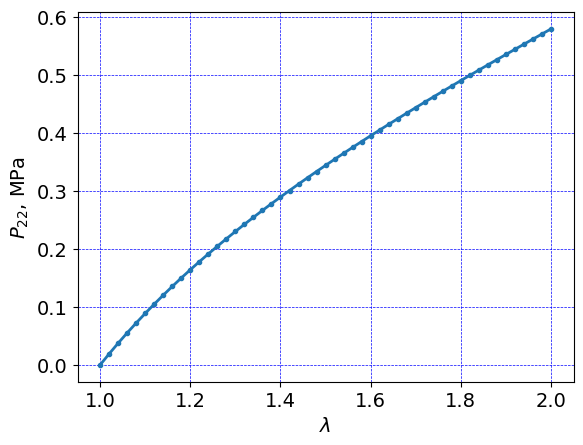

<Figure size 700x500 with 0 Axes>

In [20]:
# set plot font to size 14
font = {'size'   : 14}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

#plt.figure()
plt.plot((length + timeHist0)/length, timeHist1/1e3, linewidth=2.0,\
         color=colors[0], marker='.')
plt.axis('tight')
plt.ylabel(r'$P_{22}$, MPa')
plt.xlabel(r'$\lambda$')
# plt.xlim([1,8])
# plt.ylim([0,8])
plt.grid(linestyle="--", linewidth=0.5, color='b')
plt.show()   

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/3D_finite_elastic_spherical_inclusion.png", dpi=600)